In [15]:
# allow interaction with the plots
%matplotlib widget

%load_ext autoreload
%autoreload 2

# add the main directory reference and import 'imports.py'
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")
from imports import *

logging.basicConfig(level=logging.ERROR)
verbosity = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
class Config(Base):
    def __init__(
        self,
        batch_size=1000,
        lr=0.001,
        hidden_size=64,
        layers=4,
        dropout=0,
        max_epochs=100,
        num_workers=0,
    ):
        self.save_attr()


params = Config()


data[-1] counts
G1_G2_S (1): 28395
Prophase (3): 545
Metaphase (2): 61
Telophase (4): 24
Anaphase (0): 14

Train Data (24 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([1000, 3, 66, 66]), torch.float32
batch[1]: torch.Size([1000]), torch.int64

First 1 samples:

Sample 0: 

tensor([[[0.4039, 0.4039, 0.4039,  ..., 0.3922, 0.3922, 0.3922],
         [0.4039, 0.4039, 0.4039,  ..., 0.3922, 0.3922, 0.3922],
         [0.4039, 0.4039, 0.4039,  ..., 0.3922, 0.3922, 0.3922],
         ...,
         [0.3843, 0.3843, 0.3843,  ..., 0.3922, 0.3922, 0.3922],
         [0.3843, 0.3843, 0.3843,  ..., 0.3922, 0.3922, 0.3922],
         [0.3843, 0.3843, 0.3843,  ..., 0.3922, 0.3922, 0.3922]],

        [[0.4039, 0.4039, 0.4039,  ..., 0.3922, 0.3922, 0.3922],
         [0.4039, 0.4039, 0.4039,  ..., 0.3922, 0.3922, 0.3922],
         [0.4039, 0.4039, 0.4039,  ..., 0.3922, 0.3922, 0.3922],
         ...,
         [0.3843, 0.3843, 0.3843,  ..., 0.3922

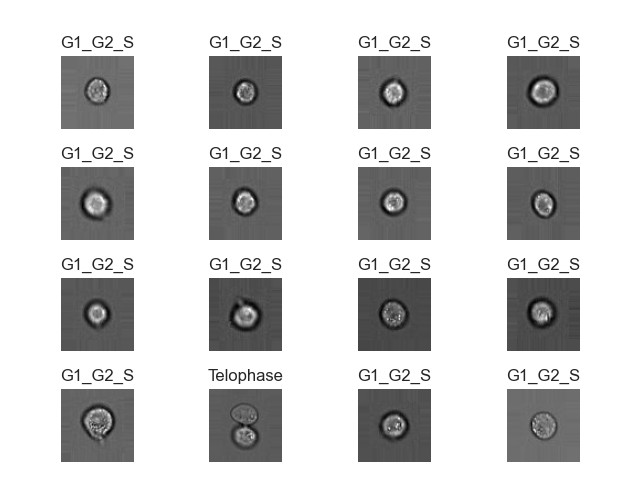

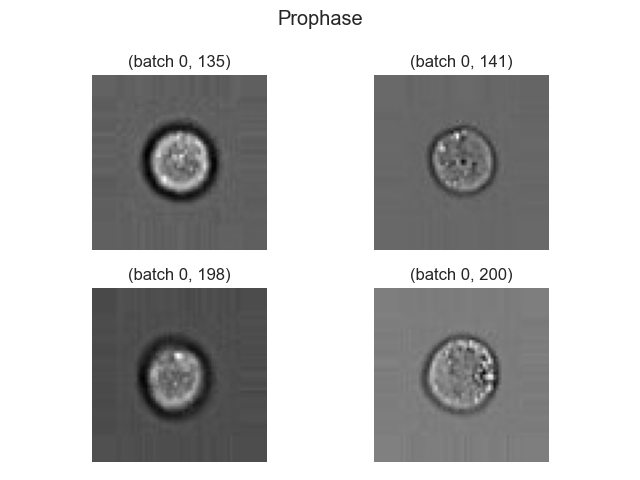

In [17]:
from data.CellCycle import Brightfield

plt.close("all")

dt = Brightfield(batch_size=params.batch_size, num_workers=16)

dt.preview(samples=1)
sample = dt.sample_batch()
dt.visualize(*sample)
dt.visualize_class(3, samples=4)


The classes are massively imbalanced. We have several strategies to combat this:
- Resampling
- Augmentation
- One-vs-All


First, however, in order to evaluate our performance, we need some metrics that represent the under-sampled classes.
- Balanced/macro versions of Accuracy/Recall/F1 work well.
- Additionally, ROC and kappa can also be illuminating for unbalanced datasets.

kappa is nice because it accounts for the chance agreement, and thus if it is >0, it shows our model is not just predicting the one imbalanced class.

Below, we will plot Accuracy and F1 for both train and validation datasets. For validation, we will also plot kappa.
We won't plot recall since, due to the imbalanced nature, it will obscure accuracy for a long while.
Finally, we display the Confusion matrices.

If the results need improvement, we will try some of our strategies.

In [18]:
from sklearn.metrics import cohen_kappa_score
from lib.metrics import *
import torcheval.metrics as ms

plt.close("all")


def init_metrics(flush_every):
    classification_val = MetricsFrame(
        [
            from_tem(
                ms.MulticlassAccuracy,
                "Accuracy",
                average="macro",
                num_classes=dt.classes,
            ),
            from_tem(
                ms.MulticlassF1Score,
                "F1",
                average="macro",
                num_classes=dt.classes,
            ),
            CatMetric("kappa", cohen_kappa_score),
        ],
        flush_every=flush_every,
    )

    classification_train = MetricsFrame(
        [
            from_tem(
                ms.MulticlassAccuracy,
                "Accuracy",
                num_classes=dt.classes,
                average="macro",
            ),
            from_tem(
                ms.MulticlassF1Score,
                "F1",
                num_classes=dt.classes,
                average="macro",
            ),
        ],
        flush_every=flush_every,
    )

    ctrain_board = ProgressBoard(
        ylabel="Percent", title="Metrics (Train)", train_prefix=""
    )
    ctrain_board.add_mf(classification_train)
    cval_board = ProgressBoard(ylabel="Percent", title="Metrics (Validation)")
    cval_board.add_mf(classification_val)
    return [classification_train], [classification_val]

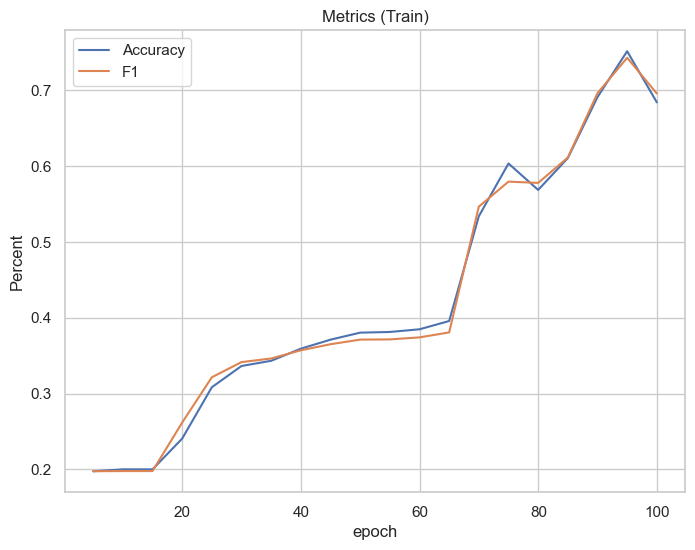

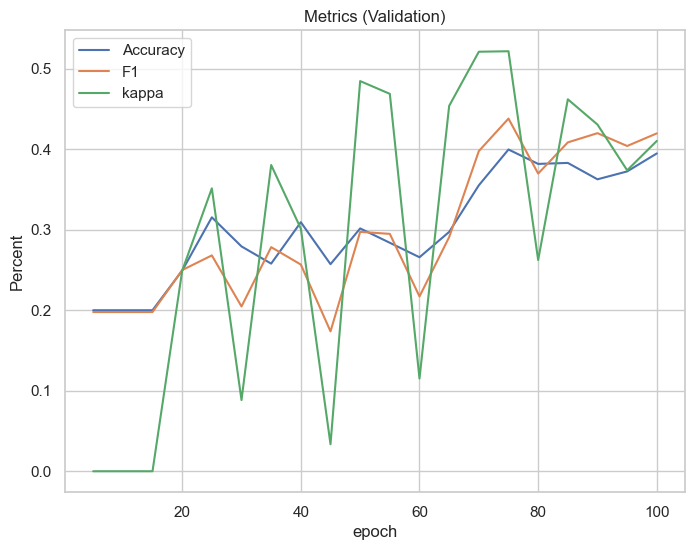

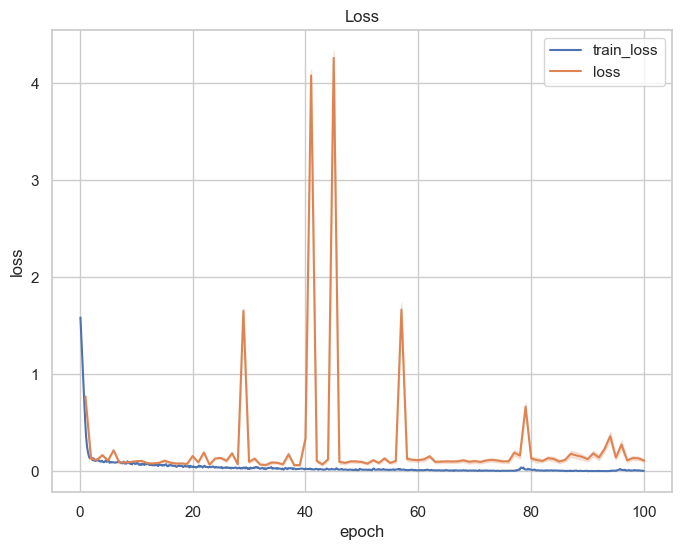

Epochs progress:   0%|          | 0/100 [00:00<?, ?Epoch/s]

tensor(0.0032, device='cuda:0')

In [19]:
from models.Convolution import CNN
from lib.train import *

plt.close("all")

model = CNN(
    dt.classes,
    conv_layers=params.layers,
    dropout=params.dropout,
)

train_mfs, val_mfs = init_metrics(5)

trainer = Trainer(
    max_epochs=params.max_epochs,
    lr=params.lr,
    train_mfs=train_mfs,
    val_mfs=val_mfs,
)
trainer.fit(model, dt.loaders())


0it [00:00, ?it/s]

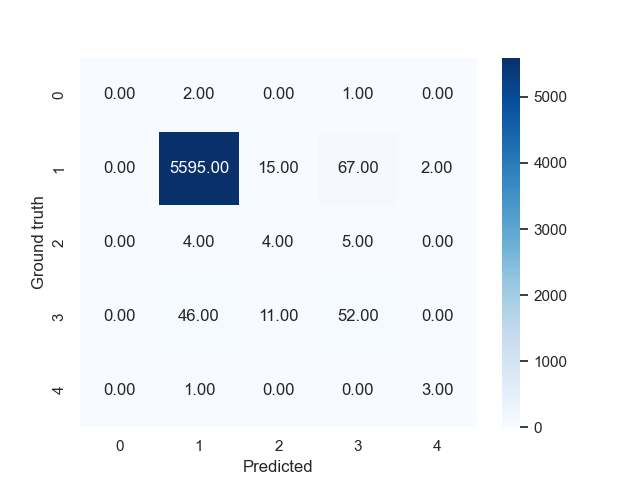

[0.503993034362793]


In [20]:
def eval_model(trainer):
    eval_ms = MetricsFrame(
        [
            from_tem(
                ms.MulticlassConfusionMatrix,
                "ConfusionMatrix",
                num_classes=dt.classes,
            ),
            from_tem(
                ms.MulticlassAccuracy,
                "Accuracy",
                average="macro",
                num_classes=dt.classes,
            ),
        ],
        flush_every=0,
        xlabel=None,
    )

    trainer.eval(
        pred=True,
        loss=True,
        mfs=eval_ms,
    )
    plot_2dheatmap(eval_ms.dict["ConfusionMatrix"][0])
    print(eval_ms.dict["Accuracy"])


eval_model(trainer)


Let's try data augmentation

data[-1] counts
G1_G2_S (1): 28395
Prophase (3): 545
Metaphase (2): 61
Telophase (4): 24
Anaphase (0): 14

Train Data (24 batches) Preview:
--------------------------------------------------
Constituent shapes:
batch[0]: torch.Size([1000, 3, 66, 66]), torch.float32
batch[1]: torch.Size([1000]), torch.int64

First 1 samples:

Sample 0: 

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,


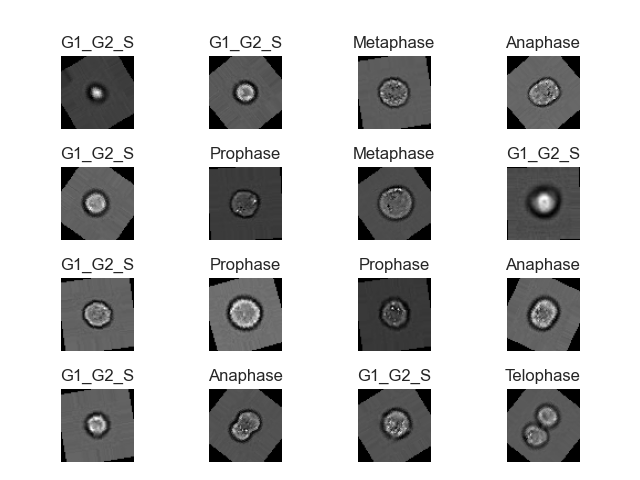

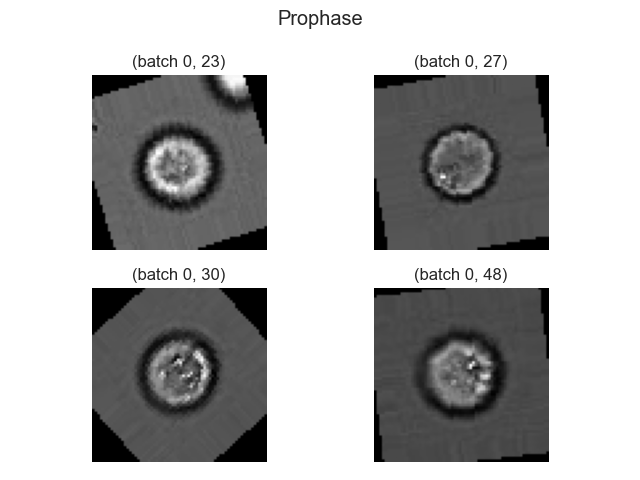

In [23]:
from data.CellCycle import Brightfield
from torchvision import transforms
from lib.data import ClassifierModule

plt.close("all")

params = Config(max_epochs=300)

transform = transforms.Compose(
    [
        # transforms.RandomResizedCrop(
        #     size=224, scale=(0.5, 1.0)
        # ),  # Random crop and resize
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=360),
        transforms.ToTensor(),
    ]
)


dt = Brightfield(
    batch_size=params.batch_size,
    num_workers=16,
    transform=transform,
    sampler=ClassifierModule.make_inverse_sampler(
        factor=0.9
    ),  # We don't make the classes completely balanced to help the model see more data
)

dt.preview(samples=1)
sample = dt.sample_batch()
dt.visualize(*sample)
dt.visualize_class(3, samples=4)


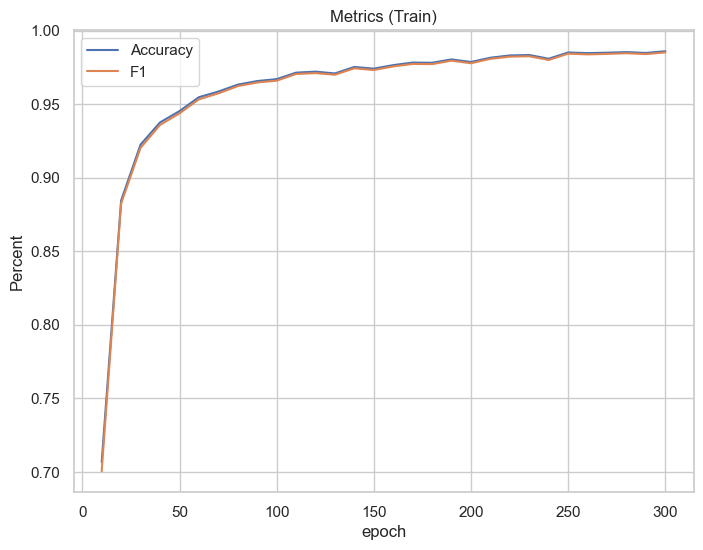

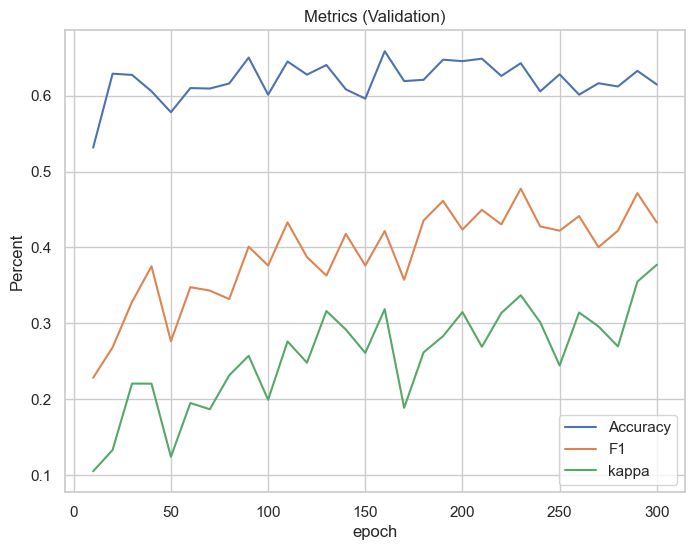

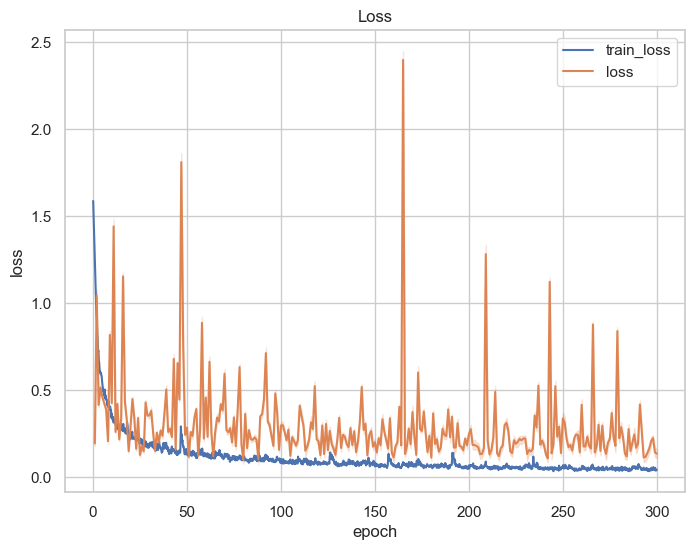

Epochs progress:   0%|          | 0/300 [00:00<?, ?Epoch/s]

tensor(0.0403, device='cuda:0')

In [24]:
from models.Convolution import CNN
from lib.train import *

plt.close("all")

model = CNN(
    dt.classes,
    conv_layers=params.layers,
    dropout=params.dropout,
)

train_mfs, val_mfs = init_metrics(10)

trainer = Trainer(
    max_epochs=params.max_epochs,
    lr=params.lr,
    train_mfs=train_mfs,
    val_mfs=val_mfs,
)

trainer.fit(model, dt.loaders())


Validation loss is much better, and validation metrics improved as well.

More importantly, it looks like there is still room to grow with continued training, in particular, the imbalanced classes are much less a hindrance, as evidenced threefold by the good training accuracy, improving validation metrics, and the lower and stabler validation loss implying the model has learned to differentiate the classes.

One thing to note is that the validation dataset was augmented with transforms this time around so it's not the exact same comparison. Also, we trained for more epochs because it seemed more promising.

0it [00:00, ?it/s]

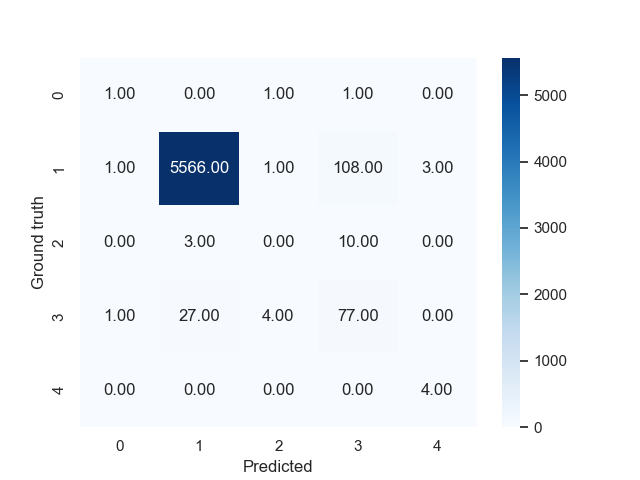

[0.603971540927887]


In [25]:
eval_model(trainer)

A lot less false positives for class 1 but seems the model prefers class 3 (Prophase) too much now. Understandable as they look quite similar. Maybe the added complexity of transforms require still more epochs? Nevertheless, most (in fact, all) metrics are improved.

In [ ]:
from models.ViT import VisionTransformer

plt.close("all")

params = Config(
    max_epochs=300,
    patch_size=?,
    hiddens=10,

)

model = CNN(
    dt.classes,
    conv_layers=params.layers,
    dropout=params.dropout,
)

train_mfs, val_mfs = init_metrics(10)

trainer = Trainer(
    max_epochs=params.max_epochs,
    lr=params.lr,
    train_mfs=train_mfs,
    val_mfs=val_mfs,
)

trainer.fit(model, dt.loaders())
